# Prediction of Optical Band Gap and Conversion Efficiency of Organic Photovoltaic Materials

## Problem Introduction

There are approximately 350 computed datas, with the measured values are **HOMO** and **LUMO** levels, the **electrochemical and optical band gaps**, the **power conversion efficiency**, **open circuit potential**, the **short-circuit current density** and the **fill factor**.

We want to **predict** the `optical band gap` and the `power conversion efficiency` of **3 target organic photovoltaic materials**.

The question is that **if it is possible to make a good prediction using generic descriptors** from available packages like rdkit and mordred, and a **careful manual modeling process**.

## Imports

In [1]:
# Useful imports

# === DATA HANDLING ===
import pandas as pd
import numpy as np
import os

# === VISUALIZATION ===
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# === MOLECULAR DESCRIPTORS ===
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import display

# Mordred for extensive molecular descriptors
from mordred import Calculator, descriptors

# === FEATURE PROCESSING ===
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

# === UNSUPERVISED LEARNING (for exploration) ===
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# === MACHINE LEARNING MODELS ===
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# === MODEL SAVING/LOADING ===
import pickle
import joblib

## Data Acquisition

In [2]:
# Show HOPV_train
df = pd.read_csv('https://raw.githubusercontent.com/Myuriin/datan/main/HOPV_train.csv')
display(df.head()) # show some of the data
display(df.info()) # show info of the data

,Unnamed: 0,SMILES,DOI,InChI_Key,construction,architecture,complement,HOMO_exp,LUMO_exp,electrochemical_gap_exp,...,HOMO_comp,LUMO_comp,electrochemical_gap_comp,optical_gap_comp,PCE_comp,V_OC_comp,J_SC_comp,fill_factor_comp,mol_obj,PCE_exp
0,329,Cn1c2ccsc2c2sc(-c3ccc(-c4ccc(-c5cccs5)c5nsnc54...,10.1021/ar900061z,VWSABRSNELBHLV-UHFFFAOYSA-N,polymer,bulk,PC61BM,-5.00,-3.43,1.57,...,-0.542126,-0.725290,0.319496,0.466492,-0.706590,-1.101829,0.170518,-0.610170,<rdkit.Chem.rdchem.Mol object at 0x00000227A83...,2.17
1,331,N#CC(=CC=Cc1ccc(N(c2ccccc2)c2ccccc2)cc1)C(=O)O,10.1039/B908802D,GGWRNMPYTNCJIV-GYZJEQCASA-N,molecule,DSSC,TiO2,NaN,NaN,NaN,...,1.522580,1.413439,-1.366698,-1.209085,0.618564,0.027464,0.522857,0.812240,<rdkit.Chem.rdchem.Mol object at 0x00000227A83...,5.30
2,3,C#Cc1cc2c(s1)c1sc(C#Cc3scc4nc(-c5ccccc5)c(-c5c...,10.1016/j.solmat.2010.05.042,GBMQZLANRSVNDA-UHFFFAOYSA-N,polymer,bulk,PC61BM,NaN,NaN,NaN,...,1.522580,1.413439,-1.366698,-1.209085,-0.888640,0.081240,-0.607653,-0.868790,<rdkit.Chem.rdchem.Mol object at 0x00000227A3D...,1.74
3,211,Cc1cc(-c2ccc(-c3cc(C)c(-c4cccs4)s3)c3nsnc32)sc...,10.1021/ja210687r,ROOICZGMEHUXNU-UHFFFAOYSA-N,polymer,bulk,PC61BM,-5.07,-3.53,1.54,...,-0.571032,-0.787643,0.287276,0.684546,-0.524540,0.081240,-0.666016,0.618275,<rdkit.Chem.rdchem.Mol object at 0x00000227A56...,2.60
4,76,CN1C(=O)C2=C(c3ccc(-c4cc5c(s4)-c4sccc4[Si]5(C)...,10.1039/C1EE01072G,LGTATYAIFFFVLT-UHFFFAOYSA-N,polymer,bulk,PC71BM,-5.04,-3.47,1.57,...,-0.558644,-0.750231,0.319496,0.271390,-0.736226,-0.940502,-0.255314,-0.157585,<rdkit.Chem.rdchem.Mol object at 0x00000227A66...,2.10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                302 non-null    int64  
 1   SMILES                    302 non-null    object 
 2   DOI                       302 non-null    object 
 3   InChI_Key                 299 non-null    object 
 4    construction             299 non-null    object 
 5    architecture             299 non-null    object 
 6    complement               299 non-null    object 
 7    HOMO_exp                 212 non-null    float64
 8    LUMO_exp                 202 non-null    float64
 9    electrochemical_gap_exp  202 non-null    float64
 10   optical_gap_exp          187 non-null    float64
 11   V_OC_exp                 294 non-null    float64
 12   J_SC_exp                 293 non-null    float64
 13   fill_factor_exp          292 non-null    float64
 14  HOMO_comp 

None

Now check the `target_molecules.csv`

In [3]:
# Show target_molecules.csv
target_df = pd.read_csv('https://raw.githubusercontent.com/Myuriin/datan/main/target_molecules.csv')
display(target_df.head()) # show some of the data
display(target_df.info()) # show info of the data

,SMILES,construction,architecture,complement
0,Cc1ccsc1-c1cc(C)c(-c2ccc(-c3cc(C)c(C4=S=C(c5cc...,polymer,bulk,PC61BM
1,COCc1cc2csc(-c3cc4c(s3)c(OC)c3ccsc3c4OC)c2s1,polymer,bulk,PC71BM
2,COc1ccc(N(c2ccc(C=Cc3cc4c(s3)-c3sc(C=C(C#N)C(=...,molecule,DSSC,TiO2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   SMILES        3 non-null      object
 1   construction  3 non-null      object
 2   architecture  3 non-null      object
 3   complement    3 non-null      object
dtypes: object(4)
memory usage: 224.0+ bytes


None

## Data Cleaning



In [4]:
# Let's make a function code that will "clean the data"
def clean(data,selected_col_list=None):
  data.columns = data.columns.str.strip() # to clean all the weird spacings

  if selected_col_list is not None:
        data = data[[col for col in selected_col_list if col in data.columns]] # get all the selected data we want. if there is none, it will just clean the spacing of the data

  display(data.head()) # show some of the data
  display(data.info()) # show info of the data

  return data

In [5]:
# Let's also clean the target data
target_df = clean(target_df)

,SMILES,construction,architecture,complement
0,Cc1ccsc1-c1cc(C)c(-c2ccc(-c3cc(C)c(C4=S=C(c5cc...,polymer,bulk,PC61BM
1,COCc1cc2csc(-c3cc4c(s3)c(OC)c3ccsc3c4OC)c2s1,polymer,bulk,PC71BM
2,COc1ccc(N(c2ccc(C=Cc3cc4c(s3)-c3sc(C=C(C#N)C(=...,molecule,DSSC,TiO2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   SMILES        3 non-null      object
 1   construction  3 non-null      object
 2   architecture  3 non-null      object
 3   complement    3 non-null      object
dtypes: object(4)
memory usage: 224.0+ bytes


None

In [6]:
# By looking at the target_molecules.csv file we notice that it only has the following features: SMILES, construction, architecture and complement
# But we also want to predict the optical band gap and PCE value for that
# -> Starting features: SMILES, construction, architecture, complement + optical_gap and PCE (both optical gap and PCE has exp and comp version)

selected_col_list = ['SMILES','construction','architecture','complement','optical_gap_exp', 'optical_gap_comp','PCE_exp', 'PCE_comp']
df = clean(df,selected_col_list)

,SMILES,construction,architecture,complement,optical_gap_exp,optical_gap_comp,PCE_exp,PCE_comp
0,Cn1c2ccsc2c2sc(-c3ccc(-c4ccc(-c5cccs5)c5nsnc54...,polymer,bulk,PC61BM,1.46,0.466492,2.17,-0.706590
1,N#CC(=CC=Cc1ccc(N(c2ccccc2)c2ccccc2)cc1)C(=O)O,molecule,DSSC,TiO2,NaN,-1.209085,5.30,0.618564
2,C#Cc1cc2c(s1)c1sc(C#Cc3scc4nc(-c5ccccc5)c(-c5c...,polymer,bulk,PC61BM,NaN,-1.209085,1.74,-0.888640
3,Cc1cc(-c2ccc(-c3cc(C)c(-c4cccs4)s3)c3nsnc32)sc...,polymer,bulk,PC61BM,1.65,0.684546,2.60,-0.524540
4,CN1C(=O)C2=C(c3ccc(-c4cc5c(s4)-c4sccc4[Si]5(C)...,polymer,bulk,PC71BM,1.29,0.271390,2.10,-0.736226


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SMILES            302 non-null    object 
 1   construction      299 non-null    object 
 2   architecture      299 non-null    object 
 3   complement        299 non-null    object 
 4   optical_gap_exp   187 non-null    float64
 5   optical_gap_comp  302 non-null    float64
 6   PCE_exp           296 non-null    float64
 7   PCE_comp          302 non-null    float64
dtypes: float64(4), object(4)
memory usage: 19.0+ KB


None

## Data Exploration

Here, we want to evaluate the data we get from the `HOPV_molecules.csv` data to see if there is any **missing values**, **trend** or something that we can work on (maybe to fill the missing values).

### Missing Values Exploration

In [7]:
# Show missing values in each columns
display(df.isna().sum())

SMILES                0
construction          3
architecture          3
complement            3
optical_gap_exp     115
optical_gap_comp      0
PCE_exp               6
PCE_comp              0
dtype: int64

As we can see, there seems to be some **missing values** for **almost all the columns**. (other than the computed data)

Most of the missing values are on the **experimental optical gap**

There are 3 types of missing values:
  1. `construction`, `architecture` and `complement`.
  2. `optical_gap_exp`
  3. `PCE_exp`

#### Construction, Architecture, and Complement Missing Values

In [8]:
# We need to see what kind of data this "construction", "architecture", and "complement" is.
# Display NaN data in "construction", "architecture", and "complement"
display(df[df['construction'].isna()])
display(df[df['architecture'].isna()])
display(df[df['complement'].isna()])

,SMILES,construction,architecture,complement,optical_gap_exp,optical_gap_comp,PCE_exp,PCE_comp
113,Cc1csc(C=Cc2cccc3nsnc32)c1C,NaN,NaN,NaN,NaN,-1.209085,NaN,-1.625307
116,Cc1csc(-c2cccc3nsnc32)c1C,NaN,NaN,NaN,NaN,-1.209085,NaN,-1.625307
149,Cc1csc(C#Cc2cccc3nsnc32)c1C,NaN,NaN,NaN,NaN,-1.209085,NaN,-1.625307


,SMILES,construction,architecture,complement,optical_gap_exp,optical_gap_comp,PCE_exp,PCE_comp
113,Cc1csc(C=Cc2cccc3nsnc32)c1C,NaN,NaN,NaN,NaN,-1.209085,NaN,-1.625307
116,Cc1csc(-c2cccc3nsnc32)c1C,NaN,NaN,NaN,NaN,-1.209085,NaN,-1.625307
149,Cc1csc(C#Cc2cccc3nsnc32)c1C,NaN,NaN,NaN,NaN,-1.209085,NaN,-1.625307


,SMILES,construction,architecture,complement,optical_gap_exp,optical_gap_comp,PCE_exp,PCE_comp
113,Cc1csc(C=Cc2cccc3nsnc32)c1C,NaN,NaN,NaN,NaN,-1.209085,NaN,-1.625307
116,Cc1csc(-c2cccc3nsnc32)c1C,NaN,NaN,NaN,NaN,-1.209085,NaN,-1.625307
149,Cc1csc(C#Cc2cccc3nsnc32)c1C,NaN,NaN,NaN,NaN,-1.209085,NaN,-1.625307


In [9]:
# So in this case, there are only 3 molecules with these kind of missing data throughout the features: -> we can delete the molecule with this kind of missing data
# Drop everything that has NaN in construction, architecture, and complement
df = df.dropna(subset=['construction', 'architecture', 'complement'])
display(df.head())
display(df.isna().sum())

,SMILES,construction,architecture,complement,optical_gap_exp,optical_gap_comp,PCE_exp,PCE_comp
0,Cn1c2ccsc2c2sc(-c3ccc(-c4ccc(-c5cccs5)c5nsnc54...,polymer,bulk,PC61BM,1.46,0.466492,2.17,-0.706590
1,N#CC(=CC=Cc1ccc(N(c2ccccc2)c2ccccc2)cc1)C(=O)O,molecule,DSSC,TiO2,NaN,-1.209085,5.30,0.618564
2,C#Cc1cc2c(s1)c1sc(C#Cc3scc4nc(-c5ccccc5)c(-c5c...,polymer,bulk,PC61BM,NaN,-1.209085,1.74,-0.888640
3,Cc1cc(-c2ccc(-c3cc(C)c(-c4cccs4)s3)c3nsnc32)sc...,polymer,bulk,PC61BM,1.65,0.684546,2.60,-0.524540
4,CN1C(=O)C2=C(c3ccc(-c4cc5c(s4)-c4sccc4[Si]5(C)...,polymer,bulk,PC71BM,1.29,0.271390,2.10,-0.736226


SMILES                0
construction          0
architecture          0
complement            0
optical_gap_exp     112
optical_gap_comp      0
PCE_exp               3
PCE_comp              0
dtype: int64

#### Optical Band Gap Missing Values

In [10]:
# Now show all the data with missing value for optical_gap_exp
df[df['optical_gap_exp'].isnull()]

,SMILES,construction,architecture,complement,optical_gap_exp,optical_gap_comp,PCE_exp,PCE_comp
1,N#CC(=CC=Cc1ccc(N(c2ccccc2)c2ccccc2)cc1)C(=O)O,molecule,DSSC,TiO2,NaN,-1.209085,5.30,0.618564
2,C#Cc1cc2c(s1)c1sc(C#Cc3scc4nc(-c5ccccc5)c(-c5c...,polymer,bulk,PC61BM,NaN,-1.209085,1.74,-0.888640
12,N#CC(=Cc1ccc(C=Cc2ccc(C=Cc3ccc(N(c4ccccc4)c4cc...,molecule,DSSC,TiO2,NaN,-1.209085,1.70,-0.905575
14,Cc1ccc(-c2nc3cccc(-c4ccc(-c5ccc6c(c5)C(C)(C)c5...,polymer,bulk,PC71BM,NaN,-1.209085,4.40,0.237529
16,Cc1ccsc1,polymer,bulk,ICBA,NaN,-1.209085,6.10,0.957261
...,...,...,...,...,...,...,...,...
286,COc1c2ccsc2c(OC)c2cc(-c3scc4sc(C(C)=O)c(F)c43)...,polymer,bulk,PC71BM,NaN,-1.209085,7.70,1.634656
288,COc1c2ccsc2c(OC)c2cc(-c3scc4sc(S(C)(=O)=O)cc43...,polymer,bulk,PC71BM,NaN,-1.209085,6.22,1.008066
294,c1csc(-c2ccsc2-c2cccs2)c1,polymer,bulk,PC61BM,NaN,-1.209085,0.58,-1.379752
300,N#CC(=Cc1sc(-c2ccc(N(c3ccccc3)c3ccccc3)cc2)c2c...,molecule,DSSC,TiO2,NaN,-1.209085,7.30,1.465308


It seems that all the missing values in `optical_gap_exp` is caused by `optical_gap_comp` which somehow has **impossibly low/negative value**:
We need to **visualize** it to determine if it's true or not.

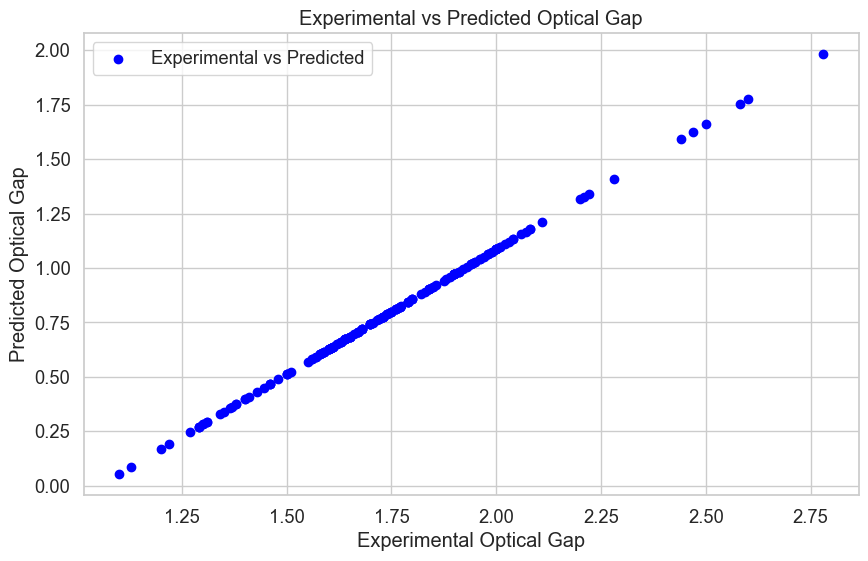

In [11]:
# We can see clearly that the computed/simulated data is not equal to the experimental data
# Create exp & predict graph to see if it's linearly correlated:
# if it is linearly correlated, maybe we can predict the missing values through linear regression?

# Plot experimental vs predicted graph
plt.figure(figsize=(10, 6))
plt.scatter(df['optical_gap_exp'], df['optical_gap_comp'], color='blue', label='Experimental vs Predicted')
plt.xlabel('Experimental Optical Gap')
plt.ylabel('Predicted Optical Gap')
plt.title('Experimental vs Predicted Optical Gap')
plt.grid(True)
plt.legend()
plt.show()

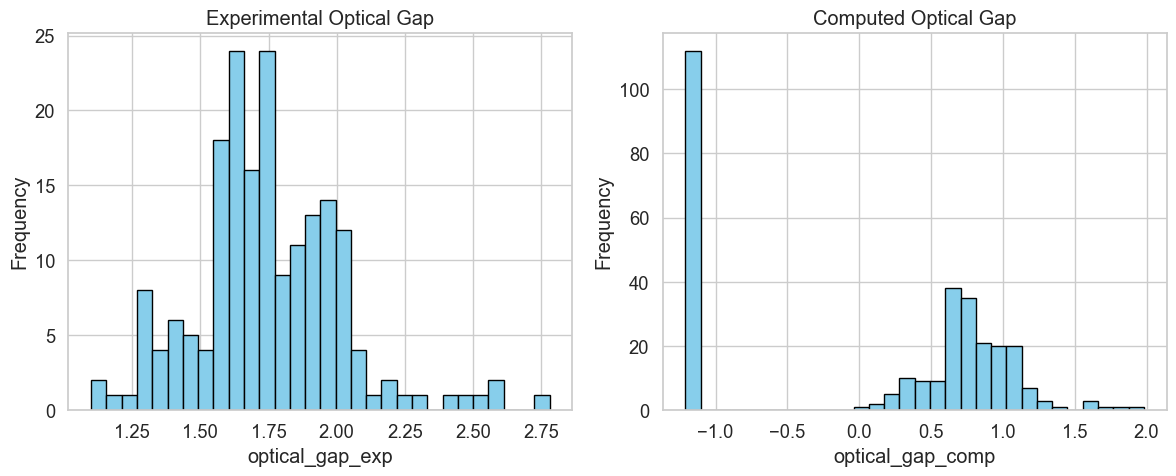

In [12]:
# Create histogram for optical_gap_comp and optical_gap_exp

# Create the function first:
def plot_histograms(df, columns, bins=30, figsize=(12, 5), layout='horizontal', titles=None):
    """
    Plot separate histograms for each specified column in the DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - columns (list of str): List of column names to plot.
    - bins (int): Number of histogram bins. Default is 30.
    - figsize (tuple): Size of the entire figure. Default is (12, 5).
    - layout (str): 'horizontal' for side-by-side, 'vertical' for stacked.
    - titles (list of str): Optional list of titles for each subplot.
    """
    n = len(columns)

    if layout == 'horizontal':
        fig, axes = plt.subplots(1, n, figsize=figsize)
    else:
        fig, axes = plt.subplots(n, 1, figsize=figsize)

    if n == 1:
        axes = [axes]  # Ensure axes is iterable

    for i, col in enumerate(columns):
        if col in df.columns:
            axes[i].hist(df[col].dropna(), bins=bins, color='skyblue', edgecolor='black')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True)
            if titles and i < len(titles):
                axes[i].set_title(titles[i])
            else:
                axes[i].set_title(f'Histogram of {col}')
        else:
            axes[i].text(0.5, 0.5, f"Column '{col}' not found", ha='center', va='center')
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()


# Create histogram
plot_histograms(df, ['optical_gap_exp', 'optical_gap_comp'], titles=['Experimental Optical Gap', 'Computed Optical Gap'])

As we can see, there is a linear correlation for computed and experimental optical gap.

Now a problem: these missing data has the same negative values (outlier) even for the computed optical gap. -> it should be treated as NaN aswell.

#### PCE Missing Value

In [13]:
# Also the PCE values of the computed/simulated data is not equal to the experimental data 
# Check if there is any correlation between the experimental data and the simulated data
# Show PCE_exp missing value data
df[df['PCE_exp'].isnull()]

,SMILES,construction,architecture,complement,optical_gap_exp,optical_gap_comp,PCE_exp,PCE_comp
17,C[Si]1(C)c2cc(-c3cnc(-c4cccs4)c4nsnc43)sc2-c2s...,molecule,bulk,PC71BM,1.68,0.718976,NaN,-1.625307
229,Cc1csc(-c2ccc(-c3cc(C)cs3)c3nsnc32)c1,molecule,bulk,PC61BM,2.04,1.132132,NaN,-1.625307
259,Cc1csc(-c2cc3c4nsnc4c(-c4cc(C)cs4)cc3c3nsnc32)c1,molecule,bulk,PC61BM,2.02,1.109179,NaN,-1.625307


Looks like the same thing is happening here in `PCE`, with the **missing values having the same values for the computed data**.

In [14]:
# We can drop missing value for PCE but not for optical band gap (since its too many)
df.dropna(subset=['PCE_exp'], inplace=True)

In [15]:
# Let's check df again
display(df.head())
display(df.info())

,SMILES,construction,architecture,complement,optical_gap_exp,optical_gap_comp,PCE_exp,PCE_comp
0,Cn1c2ccsc2c2sc(-c3ccc(-c4ccc(-c5cccs5)c5nsnc54...,polymer,bulk,PC61BM,1.46,0.466492,2.17,-0.706590
1,N#CC(=CC=Cc1ccc(N(c2ccccc2)c2ccccc2)cc1)C(=O)O,molecule,DSSC,TiO2,NaN,-1.209085,5.30,0.618564
2,C#Cc1cc2c(s1)c1sc(C#Cc3scc4nc(-c5ccccc5)c(-c5c...,polymer,bulk,PC61BM,NaN,-1.209085,1.74,-0.888640
3,Cc1cc(-c2ccc(-c3cc(C)c(-c4cccs4)s3)c3nsnc32)sc...,polymer,bulk,PC61BM,1.65,0.684546,2.60,-0.524540
4,CN1C(=O)C2=C(c3ccc(-c4cc5c(s4)-c4sccc4[Si]5(C)...,polymer,bulk,PC71BM,1.29,0.271390,2.10,-0.736226


<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 0 to 301
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SMILES            296 non-null    object 
 1   construction      296 non-null    object 
 2   architecture      296 non-null    object 
 3   complement        296 non-null    object 
 4   optical_gap_exp   184 non-null    float64
 5   optical_gap_comp  296 non-null    float64
 6   PCE_exp           296 non-null    float64
 7   PCE_comp          296 non-null    float64
dtypes: float64(4), object(4)
memory usage: 20.8+ KB


None

So the missing value of the data for experimental optical gap is 112 out of the 296 molecules -> we can only train from 184 molecules which might be too little.


Maybe separating the models is a good idea ==> make a model for PCE and a model for optical gap

### Data Visualization

In [16]:
# Remove optical_gap_comp and PCE_comp from df
df = df.drop(columns=['optical_gap_comp', 'PCE_comp'])
display(df.head())

,SMILES,construction,architecture,complement,optical_gap_exp,PCE_exp
0,Cn1c2ccsc2c2sc(-c3ccc(-c4ccc(-c5cccs5)c5nsnc54...,polymer,bulk,PC61BM,1.46,2.17
1,N#CC(=CC=Cc1ccc(N(c2ccccc2)c2ccccc2)cc1)C(=O)O,molecule,DSSC,TiO2,NaN,5.30
2,C#Cc1cc2c(s1)c1sc(C#Cc3scc4nc(-c5ccccc5)c(-c5c...,polymer,bulk,PC61BM,NaN,1.74
3,Cc1cc(-c2ccc(-c3cc(C)c(-c4cccs4)s3)c3nsnc32)sc...,polymer,bulk,PC61BM,1.65,2.60
4,CN1C(=O)C2=C(c3ccc(-c4cc5c(s4)-c4sccc4[Si]5(C)...,polymer,bulk,PC71BM,1.29,2.10


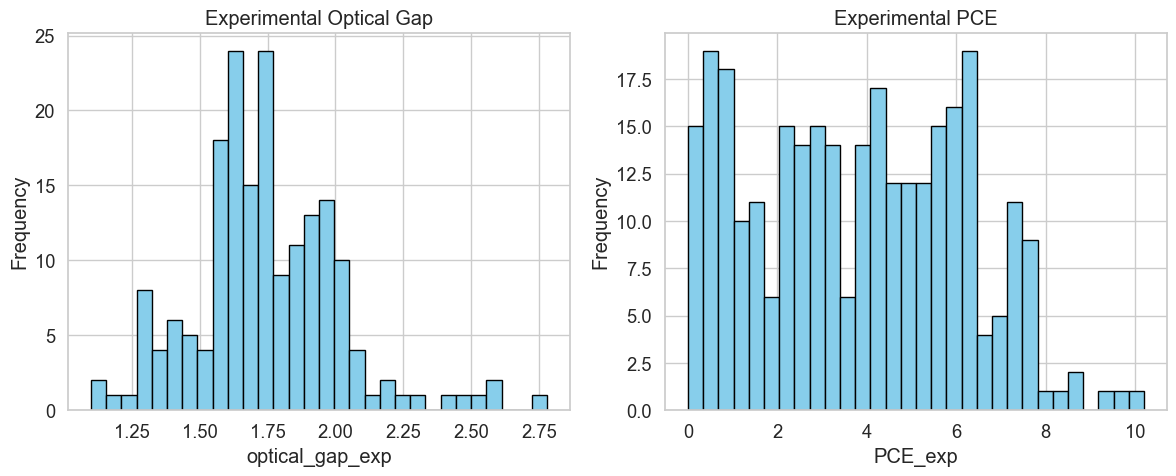

In [17]:
# Visualize the PCE and Optical Gap Through Histogram
plot_histograms(df, ['optical_gap_exp', 'PCE_exp'], titles=['Experimental Optical Gap', 'Experimental PCE'])

As we can see, ***the optical band gap data*** is more **normally distributed** than the ***PCE data***.


***PCE data*** looks more (kinda) **uniformly distributed**, this might impact the model later on.

### Check for Duplicates

In [18]:
# check if there are any duplicate SMILES 
display(df['SMILES'].duplicated().sum())

7

In [19]:
# display the column with the duplicate
display(df[df['SMILES'].duplicated()])

,SMILES,construction,architecture,complement,optical_gap_exp,PCE_exp
46,Cn1c(-c2ccc(C=C(C#N)C(=O)O)s2)ccc1-c1ccc2c(c1)...,molecule,DSSC,TiO2,NaN,6.16
135,Cn1c(-c2ccc(C=C(C#N)C(=O)O)s2)ccc1-c1ccc2c(c1)...,molecule,DSSC,TiO2,NaN,6.16
168,CC1(C)c2cc(-c3ccc(-c4ccc(C=C(C#N)C(=O)O)s4)s3)...,molecule,DSSC,TiO2,NaN,5.70
200,Cn1c(-c2ccc(C=C(C#N)C(=O)O)s2)ccc1-c1ccc2c(c1)...,molecule,DSSC,TiO2,NaN,6.18
251,CC1(C)c2cc(-c3ccc(-c4ccc(C=C(C#N)C(=O)O)s4)s3)...,molecule,DSSC,TiO2,NaN,5.70
263,Cn1c(-c2ccc(C=C(C#N)C(=O)O)s2)ccc1-c1ccc2c(c1)...,molecule,DSSC,TiO2,NaN,6.18
285,Cn1c(-c2ccc(C=C(C#N)C(=O)O)s2)ccc1-c1ccc2c(c1)...,molecule,DSSC,TiO2,NaN,6.18


It seems that the duplicates have **similar values** for `PCE_exp` and all of them also have no data for `optical_gap_exp`.

In [20]:
# display before
print(f"Number of duplicates before: {df['SMILES'].duplicated().sum()}")
print(f"Number of row (molecule) before: {df.shape[0]}")
# check how many unique SMILES before
print(f"Number of unique SMILES before: {df['SMILES'].nunique()}")
# give some spacing
print()

# filter duplicate, so that there is only 1 remaining
df = df.drop_duplicates(subset='SMILES', keep='first')

# display the number of data after
print(f"Number of duplicates after: {df['SMILES'].duplicated().sum()}")
print(f"Number of row (molecule) after: {df.shape[0]}")#
print(f"Number of unique SMILES after: {df['SMILES'].nunique()}")

Number of duplicates before: 7
Number of row (molecule) before: 296
Number of unique SMILES before: 289

Number of duplicates after: 0
Number of row (molecule) after: 289
Number of unique SMILES after: 289


As we can see, we are now ready to featurize the molecules. Our data has been cleaned

### Featurization of the data ###

In [21]:
# Let's check our data again
display(df.head())
display(df.info())

,SMILES,construction,architecture,complement,optical_gap_exp,PCE_exp
0,Cn1c2ccsc2c2sc(-c3ccc(-c4ccc(-c5cccs5)c5nsnc54...,polymer,bulk,PC61BM,1.46,2.17
1,N#CC(=CC=Cc1ccc(N(c2ccccc2)c2ccccc2)cc1)C(=O)O,molecule,DSSC,TiO2,NaN,5.30
2,C#Cc1cc2c(s1)c1sc(C#Cc3scc4nc(-c5ccccc5)c(-c5c...,polymer,bulk,PC61BM,NaN,1.74
3,Cc1cc(-c2ccc(-c3cc(C)c(-c4cccs4)s3)c3nsnc32)sc...,polymer,bulk,PC61BM,1.65,2.60
4,CN1C(=O)C2=C(c3ccc(-c4cc5c(s4)-c4sccc4[Si]5(C)...,polymer,bulk,PC71BM,1.29,2.10


<class 'pandas.core.frame.DataFrame'>
Index: 289 entries, 0 to 301
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SMILES           289 non-null    object 
 1   construction     289 non-null    object 
 2   architecture     289 non-null    object 
 3   complement       289 non-null    object 
 4   optical_gap_exp  184 non-null    float64
 5   PCE_exp          289 non-null    float64
dtypes: float64(2), object(4)
memory usage: 15.8+ KB


None

### One-Hot Encoding

We still have a categorical features on construction, architecture, and complement

Let's do one hot encoding for all of them

In [22]:
# it is necessary to encode the categorical features such as 'construction', 'architechture' and 'complement' --> using One-hot encoding
df = pd.get_dummies(df, columns=['construction', 'architecture', 'complement'])
# change only the boolean type data to integer
df = df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
display(df.head())
display(df.info())

,SMILES,optical_gap_exp,PCE_exp,construction_molecule,construction_polymer,architecture_DSSC,architecture_bilayer,architecture_bulk,complement_C60,complement_ICBA,complement_PC61BM,complement_PC71BM,complement_PDI,complement_TiO2
0,Cn1c2ccsc2c2sc(-c3ccc(-c4ccc(-c5cccs5)c5nsnc54...,1.46,2.17,0,1,0,0,1,0,0,1,0,0,0
1,N#CC(=CC=Cc1ccc(N(c2ccccc2)c2ccccc2)cc1)C(=O)O,NaN,5.30,1,0,1,0,0,0,0,0,0,0,1
2,C#Cc1cc2c(s1)c1sc(C#Cc3scc4nc(-c5ccccc5)c(-c5c...,NaN,1.74,0,1,0,0,1,0,0,1,0,0,0
3,Cc1cc(-c2ccc(-c3cc(C)c(-c4cccs4)s3)c3nsnc32)sc...,1.65,2.60,0,1,0,0,1,0,0,1,0,0,0
4,CN1C(=O)C2=C(c3ccc(-c4cc5c(s4)-c4sccc4[Si]5(C)...,1.29,2.10,0,1,0,0,1,0,0,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 289 entries, 0 to 301
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SMILES                 289 non-null    object 
 1   optical_gap_exp        184 non-null    float64
 2   PCE_exp                289 non-null    float64
 3   construction_molecule  289 non-null    int32  
 4   construction_polymer   289 non-null    int32  
 5   architecture_DSSC      289 non-null    int32  
 6   architecture_bilayer   289 non-null    int32  
 7   architecture_bulk      289 non-null    int32  
 8   complement_C60         289 non-null    int32  
 9   complement_ICBA        289 non-null    int32  
 10  complement_PC61BM      289 non-null    int32  
 11  complement_PC71BM      289 non-null    int32  
 12  complement_PDI         289 non-null    int32  
 13  complement_TiO2        289 non-null    int32  
dtypes: float64(2), int32(11), object(1)
memory usage: 21.4+ KB


None

Maybe we want to clean the missing value after featurizing the molecules?

Because we want to separate PCE and optical band gap.

### Featurization Using RDKIT

`rdkit` is used instead of `mordred` because we find `mordred` data to be **too many but also can sometimes be unreliable** (due to crashes when obtaining).

As initial model, we would try using **all the descriptors available from rdkit**.

In [23]:
# Create mol_obj from SMILES
df['mol_obj'] = df['SMILES'].apply(Chem.MolFromSmiles)
display(df.head())

,SMILES,optical_gap_exp,PCE_exp,construction_molecule,construction_polymer,architecture_DSSC,architecture_bilayer,architecture_bulk,complement_C60,complement_ICBA,complement_PC61BM,complement_PC71BM,complement_PDI,complement_TiO2,mol_obj
0,Cn1c2ccsc2c2sc(-c3ccc(-c4ccc(-c5cccs5)c5nsnc54...,1.46,2.17,0,1,0,0,1,0,0,1,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x00000201B59...
1,N#CC(=CC=Cc1ccc(N(c2ccccc2)c2ccccc2)cc1)C(=O)O,NaN,5.30,1,0,1,0,0,0,0,0,0,0,1,<rdkit.Chem.rdchem.Mol object at 0x00000201B59...
2,C#Cc1cc2c(s1)c1sc(C#Cc3scc4nc(-c5ccccc5)c(-c5c...,NaN,1.74,0,1,0,0,1,0,0,1,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x00000201B59...
3,Cc1cc(-c2ccc(-c3cc(C)c(-c4cccs4)s3)c3nsnc32)sc...,1.65,2.60,0,1,0,0,1,0,0,1,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x00000201B59...
4,CN1C(=O)C2=C(c3ccc(-c4cc5c(s4)-c4sccc4[Si]5(C)...,1.29,2.10,0,1,0,0,1,0,0,0,1,0,0,<rdkit.Chem.rdchem.Mol object at 0x00000201B59...


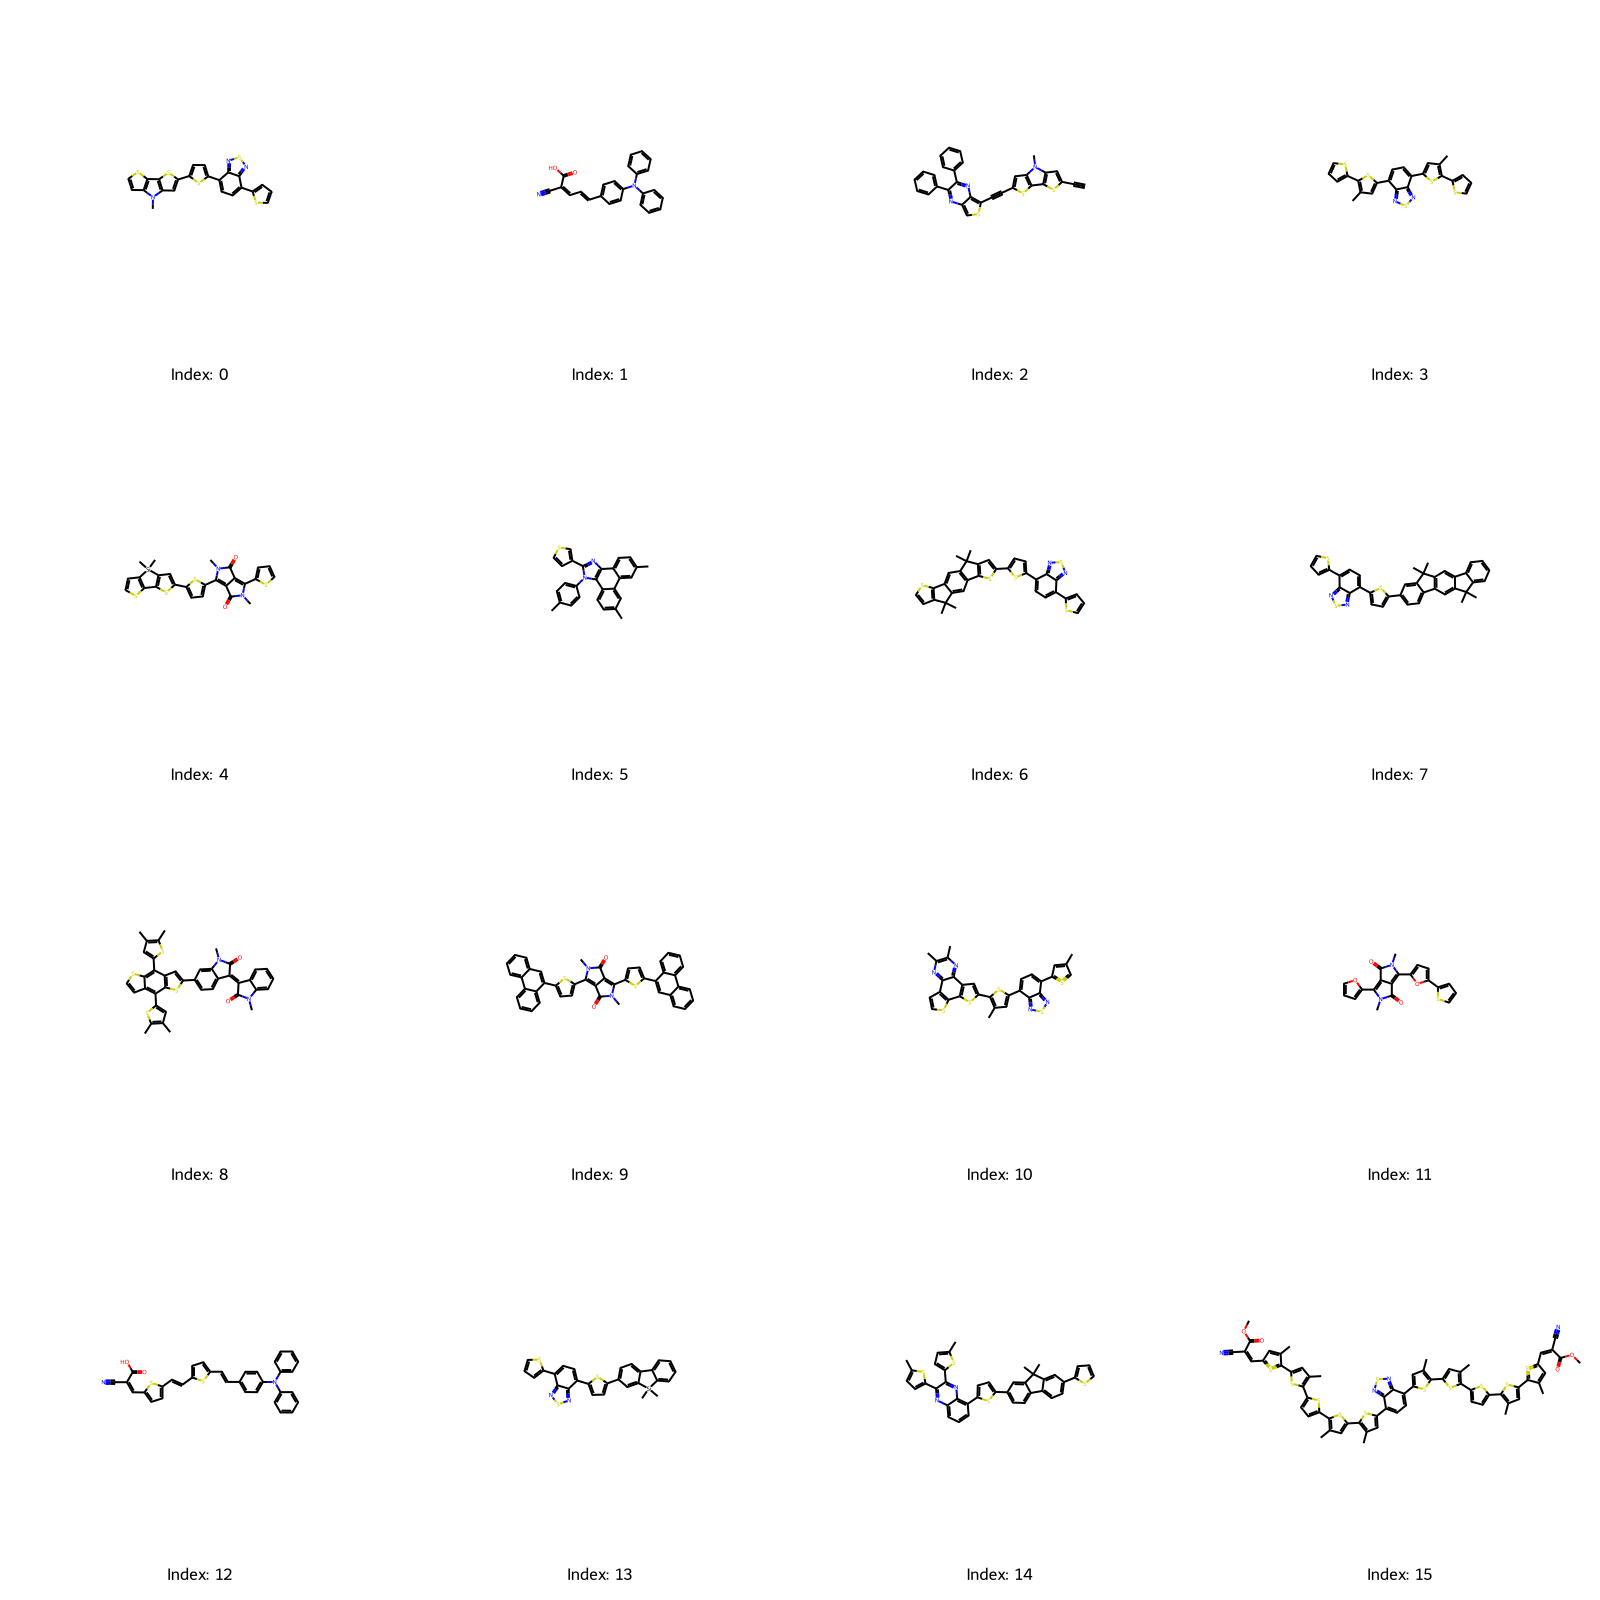

In [24]:
# Display the first 16 molecule structure
# Select the first 16 molecules and their index
subset = df.iloc[:16]
mols_to_display = subset["mol_obj"].tolist()
labels = [f"Index: {i}" for i in subset.index]

# Display with index labels
Draw.MolsToGridImage(mols_to_display, molsPerRow=4, subImgSize=(400, 400), legends=labels)

After having a look at the molecules we had the folllowing ideas to use as descriptors:


**Possible descriptors of the molecules**

- Number of rings in each molecules
- Number of aromatic rings in each molecules
- Number of thiophene functional group in each molecule
- Number of 2,1,3 benzothiadiazole functional group in each molecule
- Number of Amide functional group in each molecule
- Number of Carboxylic acid functional group in each molecule
- Number of Si atoms in each molecule
- Number of alkyne functional group in each molecule
- Number of alkene functional group in each molecule
- Number of S atoms in each molecule
- Number of O atoms in each molecule
- Number of N atoms in each molecule
- Number of Triphenylamine in each molecule
- Number of cyano functional group in each molecule
- Number of Benzene rings in each molecule
- Number of acidic groups
- Number of basic groups
- Molecular weight of the molecule

We can also make general 200 descriptors from rdkit!

#### **General molecular descriptor**


In [25]:
# Create a function to get molecule descriptors
from rdkit.Chem import AddHs

def get_descriptors(df, mol_column='mol_obj'):
    """
    Compute 200 RDKit molecular descriptors using molecules with explicit hydrogens.

    Parameters:
    - df: pandas DataFrame containing either RDKit Mol objects or SMILES strings.
    - mol_column: the column name with RDKit Mol objects (default: 'mol_obj').

    Returns:
    - DataFrame with molecular descriptors appended.
    """
    # Handle missing mol_column by generating it from 'SMILES'
    if mol_column not in df.columns:
        if 'SMILES' not in df.columns:
            raise ValueError("DataFrame must have either a 'mol_obj' column or a 'SMILES' column.")
        df = df.copy()  # Avoid changing original
        df['mol_obj'] = df['SMILES'].apply(Chem.MolFromSmiles)
        mol_column = 'mol_obj'  # Update column name

    # Prepare descriptor calculator
    descriptor_names = [desc[0] for desc in Descriptors.descList]
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

    # Function to compute descriptors with explicit Hs
    def calc_descriptors_with_Hs(mol):
        if mol is None:
            return [None] * len(descriptor_names)
        try:
            mol_with_H = AddHs(mol)
            return list(calculator.CalcDescriptors(mol_with_H))

        except:
            return [None] * len(descriptor_names)

    # Apply to molecule column
    descriptor_values = df[mol_column].apply(calc_descriptors_with_Hs)
    descriptor_df = pd.DataFrame(descriptor_values.tolist(), columns=descriptor_names)

    # Combine and return
    result_df = pd.concat([df.reset_index(drop=True), descriptor_df], axis=1)
    return result_df

In [26]:
# Apply the descriptors to the dataframe:
df_with_descriptors = get_descriptors(df)
display(df_with_descriptors.head())
display(df_with_descriptors.info())

,SMILES,optical_gap_exp,PCE_exp,construction_molecule,construction_polymer,architecture_DSSC,architecture_bilayer,architecture_bulk,complement_C60,complement_ICBA,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Cn1c2ccsc2c2sc(-c3ccc(-c4ccc(-c5cccs5)c5nsnc54...,1.46,2.17,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,4,0,0
1,N#CC(=CC=Cc1ccc(N(c2ccccc2)c2ccccc2)cc1)C(=O)O,NaN,5.30,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C#Cc1cc2c(s1)c1sc(C#Cc3scc4nc(-c5ccccc5)c(-c5c...,NaN,1.74,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,3,0,0
3,Cc1cc(-c2ccc(-c3cc(C)c(-c4cccs4)s3)c3nsnc32)sc...,1.65,2.60,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,4,0,0
4,CN1C(=O)C2=C(c3ccc(-c4cc5c(s4)-c4sccc4[Si]5(C)...,1.29,2.10,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,4,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Columns: 232 entries, SMILES to fr_urea
dtypes: float64(109), int32(11), int64(110), object(2)
memory usage: 511.5+ KB


None

Some of the **descriptors** may **have only one value** (if for example, there is no certain fuctional group present on our data): **we can drop them!**

In [27]:
# check if any column (possibly descriptors only have 1 unique value -> we can delete it because its not needed)
# create a fuction to check which column has unique values
def check_unique_value(df):
  one_value_cols_sum = 0
  for col in df.columns:
    if df[col].nunique() == 1:
      print(f"Column '{col}' has only one unique value.")
      one_value_cols_sum += 1
  if one_value_cols_sum == 0:
    print("No column has only one unique value.")
  print()
  print(f"Total number of columns with only one unique value: {one_value_cols_sum}")

check_unique_value(df_with_descriptors)

Column 'NumRadicalElectrons' has only one unique value.
Column 'SMR_VSA8' has only one unique value.
Column 'SlogP_VSA9' has only one unique value.
Column 'NumBridgeheadAtoms' has only one unique value.
Column 'NumSaturatedCarbocycles' has only one unique value.
Column 'NumSpiroAtoms' has only one unique value.
Column 'fr_Al_OH' has only one unique value.
Column 'fr_Al_OH_noTert' has only one unique value.
Column 'fr_ArN' has only one unique value.
Column 'fr_Ar_NH' has only one unique value.
Column 'fr_Ar_OH' has only one unique value.
Column 'fr_HOCCN' has only one unique value.
Column 'fr_NH1' has only one unique value.
Column 'fr_NH2' has only one unique value.
Column 'fr_N_O' has only one unique value.
Column 'fr_Ndealkylation2' has only one unique value.
Column 'fr_Nhpyrrole' has only one unique value.
Column 'fr_SH' has only one unique value.
Column 'fr_alkyl_carbamate' has only one unique value.
Column 'fr_amidine' has only one unique value.
Column 'fr_azide' has only one uniqu

In [28]:
# create function to drop the columns that have only one unique value
def drop_unique_value(df):
  one_value_cols_sum = 0
  for col in df.columns:
    if df[col].nunique() == 1:
      # drop the column
      df = df.drop(columns=[col])
      one_value_cols_sum += 1
  if one_value_cols_sum == 0:
    print("No column has only one unique value.")
  print()
  print(f"Total number of columns with only one unique value (dropped columns): {one_value_cols_sum}")

  return df

df_with_descriptors = drop_unique_value(df_with_descriptors)


Total number of columns with only one unique value (dropped columns): 50


In [29]:
# Now check for unique values again
check_unique_value(df_with_descriptors)

No column has only one unique value.

Total number of columns with only one unique value: 0


In [30]:
# Create a ready up function where it will drop all obj type columns as this data type does not work with regression
def ready_up(df):
    """
    Drops all object-type columns from the DataFrame.

    Prints the names of the dropped columns.
    Returns the cleaned DataFrame.
    """
    # Identify object-type columns
    obj_cols = df.select_dtypes(include='object').columns.tolist()

    # Print dropped columns if any
    if obj_cols:
        print("Columns dropped:", ", ".join(obj_cols))
    else:
        print("No object-type columns to drop.")

    # Drop and return cleaned DataFrame
    return df.drop(columns=obj_cols)

In [31]:
# Apply the function to the dataframe
clean_df = ready_up(df_with_descriptors)
display(clean_df.head())
display(clean_df.info())
display(clean_df.isna().sum())

Columns dropped: SMILES, mol_obj


,optical_gap_exp,PCE_exp,construction_molecule,construction_polymer,architecture_DSSC,architecture_bilayer,architecture_bulk,complement_C60,complement_ICBA,complement_PC61BM,...,fr_nitro,fr_nitro_arom,fr_para_hydroxylation,fr_pyridine,fr_sulfide,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_thiophene,fr_urea
0,1.46,2.17,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,4,0
1,NaN,5.30,1,0,1,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
2,NaN,1.74,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,3,0
3,1.65,2.60,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,4,0
4,1.29,2.10,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,4,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Columns: 180 entries, optical_gap_exp to fr_urea
dtypes: float64(107), int32(11), int64(62)
memory usage: 394.1 KB


None

optical_gap_exp          105
PCE_exp                    0
construction_molecule      0
construction_polymer       0
architecture_DSSC          0
                        ... 
fr_sulfone                 0
fr_term_acetylene          0
fr_thiazole                0
fr_thiophene               0
fr_urea                    0
Length: 180, dtype: int64

## Modeling

Now the **exciting part**!

CREATE A MODEL USING THE DATAS WE HAVE!

Now, it would be nice if we can create the model right away
But:
1. We still have NaN values
2. Some descriptors may be problematic (can have NaN, too large of a value, or have weird values)
3. We have too much descriptors
4. Most descriptors aren't needed as it may have a very low correlation

In [32]:
# For now, let's just drop all the NaN values regardless if we want to separate optical gap and PCE data
# Use dropna to remove rows with NaN values
clean_df_dropped = clean_df.dropna()

display(clean_df_dropped.head())
display(clean_df_dropped.info())
display(clean_df_dropped.isna().sum())

,optical_gap_exp,PCE_exp,construction_molecule,construction_polymer,architecture_DSSC,architecture_bilayer,architecture_bulk,complement_C60,complement_ICBA,complement_PC61BM,...,fr_nitro,fr_nitro_arom,fr_para_hydroxylation,fr_pyridine,fr_sulfide,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_thiophene,fr_urea
0,1.46,2.17,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,4,0
3,1.65,2.60,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,4,0
4,1.29,2.10,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,4,0
5,1.85,4.10,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
6,1.68,6.17,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,4,0


<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 0 to 286
Columns: 180 entries, optical_gap_exp to fr_urea
dtypes: float64(107), int32(11), int64(62)
memory usage: 250.9 KB


None

optical_gap_exp          0
PCE_exp                  0
construction_molecule    0
construction_polymer     0
architecture_DSSC        0
                        ..
fr_sulfone               0
fr_term_acetylene        0
fr_thiazole              0
fr_thiophene             0
fr_urea                  0
Length: 180, dtype: int64

In [33]:
# Make a correlation matrix to see which features are correlating with PCE_exp and optical_gap_exp, show only the correlation row for PCE_exp and optical_gap_exp

# Calculate the correlation matrix
correlation_matrix = clean_df_dropped.corr()

# Display correlation rows for PCE_exp and optical_gap_exp
print("Correlation with PCE_exp:")
display(correlation_matrix.loc['PCE_exp', :])

print("\nCorrelation with optical_gap_exp:")
display(correlation_matrix.loc['optical_gap_exp', :])

Correlation with PCE_exp:


optical_gap_exp         -0.266783
PCE_exp                  1.000000
construction_molecule   -0.109943
construction_polymer     0.109943
architecture_DSSC        0.070793
                           ...   
fr_sulfone               0.196452
fr_term_acetylene       -0.086518
fr_thiazole             -0.111621
fr_thiophene             0.424152
fr_urea                  0.012664
Name: PCE_exp, Length: 180, dtype: float64


Correlation with optical_gap_exp:


optical_gap_exp          1.000000
PCE_exp                 -0.266783
construction_molecule    0.211417
construction_polymer    -0.211417
architecture_DSSC       -0.022436
                           ...   
fr_sulfone              -0.059595
fr_term_acetylene       -0.064485
fr_thiazole              0.364516
fr_thiophene            -0.212264
fr_urea                 -0.019958
Name: optical_gap_exp, Length: 180, dtype: float64

As we can see, soo many features have an **abs(correlation) < 1**

We can remove them:

In [34]:
# Now remove the features with abs(correlation)<0,1
# We should also split the data between pce and optical gap!

## PCE
# Filter features based on correlation with PCE_exp, including NaN values
pce_corr_dropped = clean_df_dropped.corr().loc['PCE_exp', :]
pce_features_dropped = pce_corr_dropped[abs(pce_corr_dropped) > 0.1].index.tolist()
# Ensure 'PCE_exp' is included in the feature list
if 'PCE_exp' not in pce_features_dropped:
    pce_features_dropped.append('PCE_exp')

df_pce_dropped = clean_df_dropped[pce_features_dropped].copy()
print("\nDataFrame for PCE_exp (features with |corr| > 0.1) after dropping NaNs:")
# drop optical_gap_exp if it exists in the filtered features
if 'optical_gap_exp' in df_pce_dropped.columns:
    df_pce_dropped = df_pce_dropped.drop(columns=['optical_gap_exp'])
display(df_pce_dropped.head())


## Optical Gap
# Filter features based on correlation with optical_gap_exp, including NaN values
optgap_corr_dropped = clean_df_dropped.corr().loc['optical_gap_exp', :]
optgap_features_dropped = optgap_corr_dropped[abs(optgap_corr_dropped) > 0.1].index.tolist()
# Ensure 'optical_gap_exp' is included in the feature list
if 'optical_gap_exp' not in optgap_features_dropped:
    optgap_features_dropped.append('optical_gap_exp')

df_optgap_dropped = clean_df_dropped[optgap_features_dropped].copy()
print("\nDataFrame for optical_gap_exp (features with |corr| > 0.1) after dropping NaNs:")
# drop PCE_exp if it exists in the filtered features
if 'PCE_exp' in df_optgap_dropped.columns:
    df_optgap_dropped = df_optgap_dropped.drop(columns=['PCE_exp'])
display(df_optgap_dropped.head())



DataFrame for PCE_exp (features with |corr| > 0.1) after dropping NaNs:


,PCE_exp,construction_molecule,construction_polymer,complement_C60,complement_PC61BM,complement_PC71BM,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,qed,...,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_ester,fr_para_hydroxylation,fr_pyridine,fr_sulfide,fr_sulfone,fr_thiazole,fr_thiophene
0,2.17,0,1,0,1,0,8.962917,8.962917,0.051270,0.247711,...,1,1,4,0,0,0,0,0,0,4
3,2.60,0,1,0,1,0,9.037070,9.037070,0.006476,0.244988,...,0,1,1,0,0,0,0,0,0,4
4,2.10,0,1,0,0,1,14.140245,14.140245,0.006657,0.318772,...,0,0,4,0,0,0,0,0,0,4
5,4.10,0,1,0,1,0,9.113046,9.113046,0.458397,0.260584,...,0,4,6,0,0,0,0,0,0,1
6,6.17,0,1,0,0,1,9.708293,9.708293,0.006847,0.196360,...,0,2,7,0,0,0,0,0,0,4



DataFrame for optical_gap_exp (features with |corr| > 0.1) after dropping NaNs:


,optical_gap_exp,construction_molecule,construction_polymer,complement_C60,complement_PC71BM,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,qed,NumValenceElectrons,...,fr_C_O_noCOO,fr_Ndealkylation1,fr_amide,fr_aniline,fr_benzene,fr_furan,fr_nitrile,fr_para_hydroxylation,fr_thiazole,fr_thiophene
0,1.46,0,1,0,0,8.962917,8.962917,0.051270,0.247711,150,...,0,0,0,0,1,0,0,0,0,4
3,1.65,0,1,0,0,9.037070,9.037070,0.006476,0.244988,152,...,0,0,0,0,1,0,0,0,0,4
4,1.29,0,1,0,1,14.140245,14.140245,0.006657,0.318772,174,...,2,2,2,0,0,0,0,0,0,4
5,1.85,0,1,0,0,9.113046,9.113046,0.458397,0.260584,150,...,0,0,0,0,4,0,0,0,0,1
6,1.68,0,1,0,1,9.708293,9.708293,0.006847,0.196360,200,...,0,0,0,0,2,0,0,0,0,4


Now we reduced the features into just **88 features (89-1)**

In [35]:
# Separate features (X) and target (y) for PCE_exp after dropping NaNs
X_pce_dropped = df_pce_dropped.drop('PCE_exp', axis=1)
y_pce_dropped = df_pce_dropped['PCE_exp']

# Separate features (X) and target (y) for optical_gap_exp after dropping NaNs
X_optgap_dropped = df_optgap_dropped.drop('optical_gap_exp', axis=1)
y_optgap_dropped = df_optgap_dropped['optical_gap_exp']

# Show X_pce_dropped and X_optgap_dropped
display(X_pce_dropped.head())
display(X_optgap_dropped.head())

,construction_molecule,construction_polymer,complement_C60,complement_PC61BM,complement_PC71BM,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_ester,fr_para_hydroxylation,fr_pyridine,fr_sulfide,fr_sulfone,fr_thiazole,fr_thiophene
0,0,1,0,1,0,8.962917,8.962917,0.051270,0.247711,491.713,...,1,1,4,0,0,0,0,0,0,4
3,0,1,0,1,0,9.037070,9.037070,0.006476,0.244988,492.741,...,0,1,1,0,0,0,0,0,0,4
4,0,1,0,0,1,14.140245,14.140245,0.006657,0.318772,548.812,...,0,0,4,0,0,0,0,0,0,4
5,0,1,0,1,0,9.113046,9.113046,0.458397,0.260584,418.565,...,0,4,6,0,0,0,0,0,0,1
6,0,1,0,0,1,9.708293,9.708293,0.006847,0.196360,620.915,...,0,2,7,0,0,0,0,0,0,4


,construction_molecule,construction_polymer,complement_C60,complement_PC71BM,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,qed,NumValenceElectrons,MaxPartialCharge,...,fr_C_O_noCOO,fr_Ndealkylation1,fr_amide,fr_aniline,fr_benzene,fr_furan,fr_nitrile,fr_para_hydroxylation,fr_thiazole,fr_thiophene
0,0,1,0,0,8.962917,8.962917,0.051270,0.247711,150,0.113599,...,0,0,0,0,1,0,0,0,0,4
3,0,1,0,0,9.037070,9.037070,0.006476,0.244988,152,0.113599,...,0,0,0,0,1,0,0,0,0,4
4,0,1,0,1,14.140245,14.140245,0.006657,0.318772,174,0.260649,...,2,2,2,0,0,0,0,0,0,4
5,0,1,0,0,9.113046,9.113046,0.458397,0.260584,150,0.146113,...,0,0,0,0,4,0,0,0,0,1
6,0,1,0,1,9.708293,9.708293,0.006847,0.196360,200,0.113599,...,0,0,0,0,2,0,0,0,0,4


In [36]:
# Split data into training and testing sets for PCE_exp after dropping NaNs
X_train_pce_dropped, X_test_pce_dropped, y_train_pce_dropped, y_test_pce_dropped = train_test_split(X_pce_dropped, y_pce_dropped, test_size=0.2, random_state=42)

# Split data into training and testing sets for optical_gap_exp after dropping NaNs
X_train_optgap_dropped, X_test_optgap_dropped, y_train_optgap_dropped, y_test_optgap_dropped = train_test_split(X_optgap_dropped, y_optgap_dropped, test_size=0.2, random_state=42)

In [37]:
# Initialize and train the RandomForestRegressor model for PCE_exp after dropping NaNs
rf_model_pce_dropped = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_pce_dropped.fit(X_train_pce_dropped, y_train_pce_dropped)
y_pred_pce_dropped = rf_model_pce_dropped.predict(X_test_pce_dropped)
mse_pce_dropped = mean_squared_error(y_test_pce_dropped, y_pred_pce_dropped)
r2_pce_dropped = r2_score(y_test_pce_dropped, y_pred_pce_dropped)

print(f"\nRandom Forest Model for PCE_exp (after dropping NaNs and feature selection):")
print(f"  Mean Squared Error: {mse_pce_dropped:.4f}")
print(f"  R-squared: {r2_pce_dropped:.4f}")

# Initialize and train the RandomForestRegressor model for optical_gap_exp after dropping NaNs
rf_model_optgap_dropped = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_optgap_dropped.fit(X_train_optgap_dropped, y_train_optgap_dropped)
y_pred_optgap_dropped = rf_model_optgap_dropped.predict(X_test_optgap_dropped)
mse_optgap_dropped = mean_squared_error(y_test_optgap_dropped, y_pred_optgap_dropped)
r2_optgap_dropped = r2_score(y_test_optgap_dropped, y_pred_optgap_dropped)

print(f"\nRandom Forest Model for optical_gap_exp (after dropping NaNs and feature selection):")
print(f"  Mean Squared Error: {mse_optgap_dropped:.4f}")
print(f"  R-squared: {r2_optgap_dropped:.4f}")


Random Forest Model for PCE_exp (after dropping NaNs and feature selection):
  Mean Squared Error: 2.5906
  R-squared: 0.5201

Random Forest Model for optical_gap_exp (after dropping NaNs and feature selection):
  Mean Squared Error: 0.0277
  R-squared: 0.7234


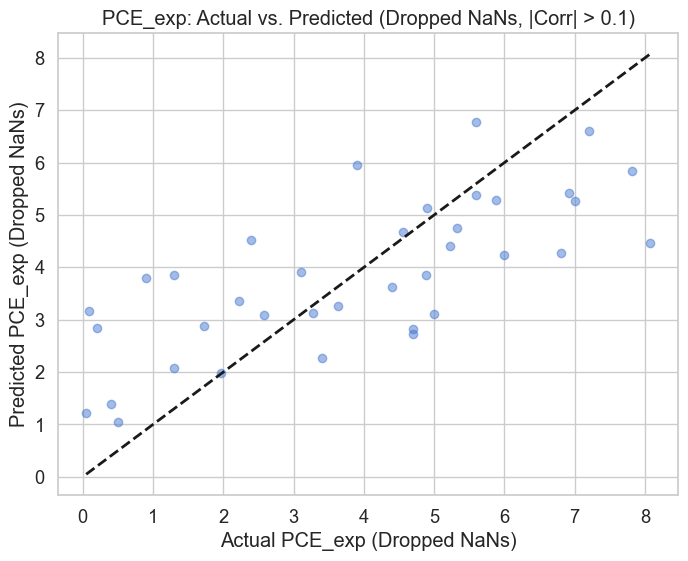

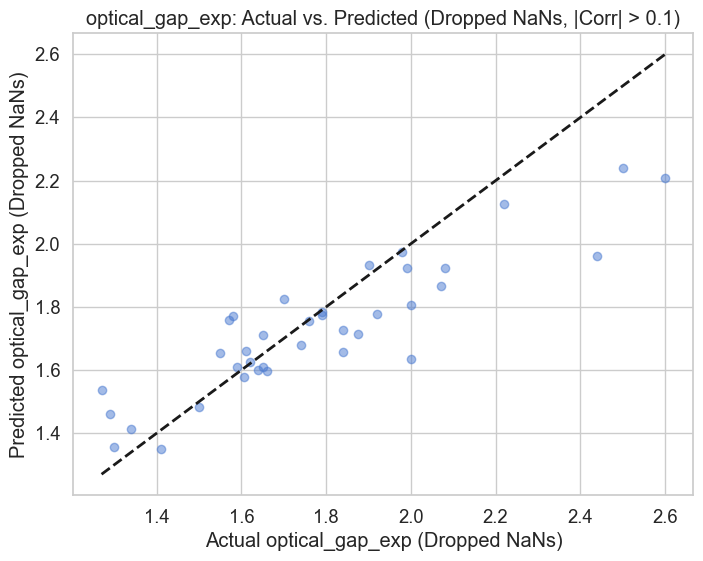

In [38]:
# Plotting results after dropping NaNs and feature selection
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pce_dropped, y_pred_pce_dropped, alpha=0.5)
plt.xlabel("Actual PCE_exp (Dropped NaNs)")
plt.ylabel("Predicted PCE_exp (Dropped NaNs)")
plt.title("PCE_exp: Actual vs. Predicted (Dropped NaNs, |Corr| > 0.1)")
plt.plot([y_test_pce_dropped.min(), y_test_pce_dropped.max()], [y_test_pce_dropped.min(), y_test_pce_dropped.max()], 'k--', lw=2)
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test_optgap_dropped, y_pred_optgap_dropped, alpha=0.5)
plt.xlabel("Actual optical_gap_exp (Dropped NaNs)")
plt.ylabel("Predicted optical_gap_exp (Dropped NaNs)")
plt.title("optical_gap_exp: Actual vs. Predicted (Dropped NaNs, |Corr| > 0.1)")
plt.plot([y_test_optgap_dropped.min(), y_test_optgap_dropped.max()], [y_test_optgap_dropped.min(), y_test_optgap_dropped.max()], 'k--', lw=2)
plt.grid(True)
plt.show()


The result looks nice for `optical_gap`, but it may be good to improve on `PCE`

### Model Improvement
For optical gap model, we think it's enough.
But PCE model might be better if we can improve them

In [39]:
# Now before this, we drop NaN based on optical gap, resulting in a fewer samples for PCE aswell.
# Let's try to not drop any NaN, as the NaN only comes from optical gap.

clean_df_new = clean_df
display(clean_df_new.head())
display(clean_df_new.info())
display(clean_df_new.isna().sum())

,optical_gap_exp,PCE_exp,construction_molecule,construction_polymer,architecture_DSSC,architecture_bilayer,architecture_bulk,complement_C60,complement_ICBA,complement_PC61BM,...,fr_nitro,fr_nitro_arom,fr_para_hydroxylation,fr_pyridine,fr_sulfide,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_thiophene,fr_urea
0,1.46,2.17,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,4,0
1,NaN,5.30,1,0,1,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
2,NaN,1.74,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,3,0
3,1.65,2.60,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,4,0
4,1.29,2.10,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,4,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Columns: 180 entries, optical_gap_exp to fr_urea
dtypes: float64(107), int32(11), int64(62)
memory usage: 394.1 KB


None

optical_gap_exp          105
PCE_exp                    0
construction_molecule      0
construction_polymer       0
architecture_DSSC          0
                        ... 
fr_sulfone                 0
fr_term_acetylene          0
fr_thiazole                0
fr_thiophene               0
fr_urea                    0
Length: 180, dtype: int64

In [40]:
# Do another correlation matrix for PCE
# Calculate the correlation matrix
correlation_matrix_new = clean_df_new.corr()

# Display correlation rows for PCE_exp and optical_gap_exp
print("Correlation with PCE_exp:")
display(correlation_matrix_new.loc['PCE_exp', :])

Correlation with PCE_exp:


optical_gap_exp         -0.265173
PCE_exp                  1.000000
construction_molecule    0.030911
construction_polymer    -0.030911
architecture_DSSC        0.348445
                           ...   
fr_sulfone               0.154819
fr_term_acetylene       -0.120305
fr_thiazole             -0.067090
fr_thiophene             0.107106
fr_urea                  0.007565
Name: PCE_exp, Length: 180, dtype: float64

In [41]:
# Now remove the features with abs(correlation)<0,1

## PCE
# Filter features based on correlation with PCE_exp, including NaN values
pce_corr_new = clean_df_new.corr().loc['PCE_exp', :]
pce_features_new = pce_corr_new[abs(pce_corr_new) > 0.1].index.tolist()
# Ensure 'PCE_exp' is included in the feature list
if 'PCE_exp' not in pce_features_new:
    pce_features_new.append('PCE_exp')

df_pce_new = clean_df_new[pce_features_new].copy()
print("\nDataFrame for PCE_exp (features with |corr| > 0.1) after dropping NaNs:")
# drop optical_gap_exp if it exists in the filtered features
if 'optical_gap_exp' in df_pce_new.columns:
    df_pce_new = df_pce_new.drop(columns=['optical_gap_exp'])
display(df_pce_new.head())


DataFrame for PCE_exp (features with |corr| > 0.1) after dropping NaNs:


,PCE_exp,architecture_DSSC,architecture_bilayer,architecture_bulk,complement_C60,complement_PC61BM,complement_PC71BM,complement_TiO2,MaxAbsEStateIndex,MaxEStateIndex,...,fr_COO,fr_COO2,fr_C_O,fr_C_S,fr_aldehyde,fr_allylic_oxid,fr_bicyclic,fr_sulfone,fr_term_acetylene,fr_thiophene
0,2.17,0,0,1,0,1,0,0,8.962917,8.962917,...,0,0,0,0,0,0,4,0,0,4
1,5.30,1,0,0,0,0,0,1,11.672042,11.672042,...,1,1,1,0,0,2,0,0,0,0
2,1.74,0,0,1,0,1,0,0,8.903838,8.903838,...,0,0,0,0,0,0,4,0,1,3
3,2.60,0,0,1,0,1,0,0,9.037070,9.037070,...,0,0,0,0,0,0,1,0,0,4
4,2.10,0,0,1,0,0,1,0,14.140245,14.140245,...,0,0,2,0,0,0,4,0,0,4


In [42]:
# Let's do the train-test split, model creation and evaluation in one go!

# Separate features (X) and target (y) for PCE_exp (after correlation filtering)
X_pce_new = df_pce_new.drop('PCE_exp', axis=1)
y_pce_new = df_pce_new['PCE_exp']

# Split data into training and testing sets for PCE_exp
X_train_pce_new, X_test_pce_new, y_train_pce_new, y_test_pce_new = train_test_split(
    X_pce_new, y_pce_new, test_size=0.2, random_state=42
)

# Initialize and train the RandomForestRegressor model for PCE_exp
rf_model_pce_new = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_pce_new.fit(X_train_pce_new, y_train_pce_new)
y_pred_pce_new = rf_model_pce_new.predict(X_test_pce_new)

# Evaluate model performance
mse_pce_new = mean_squared_error(y_test_pce_new, y_pred_pce_new)
r2_pce_new = r2_score(y_test_pce_new, y_pred_pce_new)

print(f"\nRandom Forest Model for PCE_exp (after correlation filtering, df_pce_new):")
print(f"  Mean Squared Error: {mse_pce_new:.4f}")
print(f"  R-squared: {r2_pce_new:.4f}")



Random Forest Model for PCE_exp (after correlation filtering, df_pce_new):
  Mean Squared Error: 2.8045
  R-squared: 0.5231


Only slight improvement, but now we know for `optical gap`: we use `df_optgap_dropped` and for `PCE`: we use `df_pce_new`

In [43]:
# Try using XGBoost

## PCE
# Initialize and train the XGBoost model for PCE_exp
xgb_model_pce = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model_pce.fit(X_train_pce_new, y_train_pce_new)
y_pred_pce_xgb = xgb_model_pce.predict(X_test_pce_new)

# Evaluate model performance
mse_pce_xgb = mean_squared_error(y_test_pce_new, y_pred_pce_xgb)
r2_pce_xgb = r2_score(y_test_pce_new, y_pred_pce_xgb)

print(f"\nXGBoost for PCE_exp (after correlation filtering, df_pce_new):")
print(f"  Mean Squared Error: {mse_pce_xgb:.4f}")
print(f"  R-squared: {r2_pce_xgb:.4f}")

## Optical Gap
# Initialize and train the XGBoost model for optical_gap_exp
xgb_model_optgap = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model_optgap.fit(X_train_optgap_dropped, y_train_optgap_dropped)
y_pred_optgap_xgb = xgb_model_optgap.predict(X_test_optgap_dropped)

# Evaluate model performance
mse_optgap_xgb = mean_squared_error(y_test_optgap_dropped, y_pred_optgap_xgb)
r2_optgap_xgb = r2_score(y_test_optgap_dropped, y_pred_optgap_xgb)

print(f"\nXGBoost Model for optical_gap_exp (after dropping NaNs and feature selection):")
print(f"  Mean Squared Error: {mse_optgap_xgb:.4f}")
print(f"  R-squared: {r2_optgap_xgb:.4f}")


XGBoost for PCE_exp (after correlation filtering, df_pce_new):
  Mean Squared Error: 3.1744
  R-squared: 0.4602

XGBoost Model for optical_gap_exp (after dropping NaNs and feature selection):
  Mean Squared Error: 0.0242
  R-squared: 0.7579


This improved the `optical gap` model even further, but fail at `PCE`

### Saving the Model

In [44]:
# Create a fuction to save the model
def save_model(model, X_train, filename):
    """
    Save a trained model with its feature names into a pickle file.
    
    Args:
        model: trained sklearn or xgboost model
        X_train (pd.DataFrame): training features used to fit the model
        filename (str): output pickle file name
    """
    # Store feature names inside the model object
    model.feature_names = list(X_train.columns)
    
    # Save the model
    with open(filename, "wb") as f:
        pickle.dump(model, f)
    
    print(f"✅ Model saved to {filename} with {len(model.feature_names)} features.")

In [45]:
save_model(rf_model_pce_new, X_pce_new, "rf_model_pce.pkl")

✅ Model saved to rf_model_pce.pkl with 66 features.


In [46]:
save_model(xgb_model_optgap, X_train_optgap_dropped, "xgb_model_optgap.pkl")

✅ Model saved to xgb_model_optgap.pkl with 88 features.


In [47]:
# Load the saved model
with open("rf_model_pce.pkl", "rb") as f:
    model = pickle.load(f)

# Now check feature_names
print(model.feature_names)

['architecture_DSSC', 'architecture_bilayer', 'architecture_bulk', 'complement_C60', 'complement_PC61BM', 'complement_PC71BM', 'complement_TiO2', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'SPS', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRLOW', 'Chi4v', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA3', 'PEOE_VSA6', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA5', 'SMR_VSA7', 'SlogP_VSA3', 'SlogP_VSA6', 'TPSA', 'EState_VSA11', 'EState_VSA7', 'VSA_EState10', 'VSA_EState2', 'VSA_EState5', 'VSA_EState8', 'FractionCSP3', 'NHOHCount', 'NOCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'fr_Al_COO', 'fr_Ar_N', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_S', 'fr_aldehyde', 'fr_allylic_oxid', 'fr_bicyclic

### Model evaluation with Test Set ###

Our best model so far for `PCE` is `rf_model_pce_new` and for `Optical Gap` is `xgb_model_optgap`

In [48]:
# Make the target data have the same features as the data we train
# Let's check on the target data first
target_df_new = target_df.copy()
display(target_df.head())

,SMILES,construction,architecture,complement
0,Cc1ccsc1-c1cc(C)c(-c2ccc(-c3cc(C)c(C4=S=C(c5cc...,polymer,bulk,PC61BM
1,COCc1cc2csc(-c3cc4c(s3)c(OC)c3ccsc3c4OC)c2s1,polymer,bulk,PC71BM
2,COc1ccc(N(c2ccc(C=Cc3cc4c(s3)-c3sc(C=C(C#N)C(=...,molecule,DSSC,TiO2


In [49]:
# Create a function to automize target -> target with features ready
# Step 1: Until getting descriptors
def target_ready_step1(target_df):
    # Data Cleaning
    target_df = clean(target_df)
    
    # One-Hot Encoding
    # it is necessary to encode the categorical features such as 'construction', 'architechture' and 'complement' --> using One-hot encoding
    target_df = pd.get_dummies(target_df, columns=['construction', 'architecture', 'complement'])
    # change only the boolean type data to integer
    target_df = target_df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
    
    # Get Descriptors
    target_df = get_descriptors(target_df)
    
    # Ready Up
    target_df = ready_up(target_df)
    
    return target_df

# Step 2: Match features to model training set
def target_ready_step2(target_df, model_df):
    """
    Ensure that target_df has the same feature columns as model_df.
    Works for:
    - Only PCE_exp present
    - Only optical_gap_exp present
    - Both present
    - Neither present (already features only)
    """
    # Identify possible target columns
    possible_targets = ["PCE_exp", "optical_gap_exp"]
    present_targets = [col for col in possible_targets if col in model_df.columns]
    
    # Drop target columns if present
    if present_targets:
        model_features = model_df.drop(columns=present_targets).columns
    else:
        model_features = model_df.columns
    
    # Add missing columns to target_df
    for col in model_features:
        if col not in target_df.columns:
            target_df[col] = 0
    
    # Keep only model features
    target_df = target_df[model_features]
    
    return target_df

In [50]:
def target_ready_step2_model(target_df, model):
    """
    Align target_df to the features expected by a trained model.
    
    Works with models saved using `save_model` (which stores .feature_names).
    
    - Adds missing columns (filled with 0)
    - Drops extra columns
    - Reorders columns to match model
    
    Args:
        target_df (pd.DataFrame): dataframe with descriptors & features
        model: trained model with .feature_names attribute
    
    Returns:
        pd.DataFrame: aligned features ready for prediction
    """
    # Load the saved model
    with open(model, "rb") as f:
        model = pickle.load(f)
    
    model_features = model.feature_names

    # Add missing columns
    missing_cols = [col for col in model_features if col not in target_df.columns]
    for col in missing_cols:
        target_df[col] = 0

    # Drop extra columns
    extra_cols = [col for col in target_df.columns if col not in model_features]
    if extra_cols:
        print(f"⚠️ Dropping {len(extra_cols)} extra columns: {extra_cols}")
        target_df = target_df.drop(columns=extra_cols)

    # Reorder columns
    target_df = target_df[model_features]

    print(f"✅ Features aligned: {len(model_features)} expected, {len(target_df.columns)} matched.")

    return target_df

In [51]:
target_df = target_ready_step1(target_df)
target_df_pce = target_ready_step2_model(target_df, "rf_model_pce.pkl")
target_df_optgap = target_ready_step2_model(target_df, "xgb_model_optgap.pkl")

display(target_df_pce.head())
display(target_df_optgap.head())

,SMILES,construction,architecture,complement
0,Cc1ccsc1-c1cc(C)c(-c2ccc(-c3cc(C)c(C4=S=C(c5cc...,polymer,bulk,PC61BM
1,COCc1cc2csc(-c3cc4c(s3)c(OC)c3ccsc3c4OC)c2s1,polymer,bulk,PC71BM
2,COc1ccc(N(c2ccc(C=Cc3cc4c(s3)-c3sc(C=C(C#N)C(=...,molecule,DSSC,TiO2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   SMILES        3 non-null      object
 1   construction  3 non-null      object
 2   architecture  3 non-null      object
 3   complement    3 non-null      object
dtypes: object(4)
memory usage: 224.0+ bytes


None

Columns dropped: SMILES, mol_obj
⚠️ Dropping 163 extra columns: ['construction_molecule', 'construction_polymer ', 'architecture_bulk ', 'complement_PC61BM ', 'complement_PC71BM ', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_MRHI', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA2', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA7', 'SMR_VSA2', 'SMR_VSA4', 'SMR_VSA6', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'EState_VSA1', 'EState_VSA10', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_EState3', 'VSA_EState4', 'VSA

,architecture_DSSC,architecture_bilayer,architecture_bulk,complement_C60,complement_PC61BM,complement_PC71BM,complement_TiO2,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,...,fr_COO,fr_COO2,fr_C_O,fr_C_S,fr_aldehyde,fr_allylic_oxid,fr_bicyclic,fr_sulfone,fr_term_acetylene,fr_thiophene
0,0,0,0,0,0,0,0,9.773077,9.773077,0.281784,...,0,0,0,0,0,2,7,0,0,3
1,0,0,0,0,0,0,0,9.046446,9.046446,0.026779,...,0,0,0,0,0,0,3,0,0,4
2,1,0,0,0,0,0,1,12.202355,12.202355,0.202840,...,1,1,1,0,0,0,3,0,0,2


,construction_molecule,construction_polymer,complement_C60,complement_PC71BM,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,qed,NumValenceElectrons,MaxPartialCharge,...,fr_C_O_noCOO,fr_Ndealkylation1,fr_amide,fr_aniline,fr_benzene,fr_furan,fr_nitrile,fr_para_hydroxylation,fr_thiazole,fr_thiophene
0,0,0,0,0,9.773077,9.773077,0.281784,0.162523,268,0.113609,...,0,0,0,0,4,0,0,1,0,3
1,0,0,0,0,9.046446,9.046446,0.026779,0.293274,138,0.145115,...,0,0,0,0,1,0,0,0,0,4
2,1,0,0,0,12.202355,12.202355,0.202840,0.128963,224,0.345992,...,0,0,0,3,3,0,1,0,0,2


In [52]:
# Create a feature matching function
def match_features(new_df, model_df, target_cols=["PCE_exp", "optical_gap_exp"]):
    """
    Check if new_df has exactly the same feature columns as model_df.
    
    - Drops target columns from model_df for comparison
    - Reports missing or extra columns
    - Does NOT auto-fix anything
    - Only reorders if features match perfectly
    
    Returns:
        aligned_df (DataFrame) if features match
    """
    # Drop target columns if they exist in model_df
    model_features = [col for col in model_df.columns if col not in target_cols]

    # Find missing and extra columns
    missing_cols = [col for col in model_features if col not in new_df.columns]
    extra_cols = [col for col in new_df.columns if col not in model_features]

    # Print counts for clarity
    print(f"📊 model_df has {len(model_features)} feature columns")
    print(f"📊 new_df has {new_df.shape[1]} columns")

    if missing_cols:
        print(f"❌ Missing columns: {missing_cols}")
    if extra_cols:
        print(f"⚠️ Extra columns: {extra_cols}")

    # Stop if mismatch
    if missing_cols or extra_cols:
        raise ValueError("Feature mismatch: columns do not match exactly!")

    # Reorder to match model
    aligned_df = new_df[model_features]
    print("✅ Features match perfectly.")
    
    return aligned_df


In [53]:
match_features(target_df_pce, df_pce_new)

📊 model_df has 66 feature columns
📊 new_df has 66 columns
✅ Features match perfectly.


,architecture_DSSC,architecture_bilayer,architecture_bulk,complement_C60,complement_PC61BM,complement_PC71BM,complement_TiO2,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,...,fr_COO,fr_COO2,fr_C_O,fr_C_S,fr_aldehyde,fr_allylic_oxid,fr_bicyclic,fr_sulfone,fr_term_acetylene,fr_thiophene
0,0,0,0,0,0,0,0,9.773077,9.773077,0.281784,...,0,0,0,0,0,2,7,0,0,3
1,0,0,0,0,0,0,0,9.046446,9.046446,0.026779,...,0,0,0,0,0,0,3,0,0,4
2,1,0,0,0,0,0,1,12.202355,12.202355,0.202840,...,1,1,1,0,0,0,3,0,0,2


In [54]:
match_features(target_df_optgap, df_optgap_dropped)

📊 model_df has 88 feature columns
📊 new_df has 88 columns
✅ Features match perfectly.


,construction_molecule,construction_polymer,complement_C60,complement_PC71BM,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,qed,NumValenceElectrons,MaxPartialCharge,...,fr_C_O_noCOO,fr_Ndealkylation1,fr_amide,fr_aniline,fr_benzene,fr_furan,fr_nitrile,fr_para_hydroxylation,fr_thiazole,fr_thiophene
0,0,0,0,0,9.773077,9.773077,0.281784,0.162523,268,0.113609,...,0,0,0,0,4,0,0,1,0,3
1,0,0,0,0,9.046446,9.046446,0.026779,0.293274,138,0.145115,...,0,0,0,0,1,0,0,0,0,4
2,1,0,0,0,12.202355,12.202355,0.202840,0.128963,224,0.345992,...,0,0,0,3,3,0,1,0,0,2


In [55]:
# Create a predict function
def predict(data, target="both", pce_model=None, gap_model=None):
    """
    Predict PCE and/or optical gap for new data.

    Args:
        data (pd.DataFrame): Raw input data (must include SMILES + categorical cols).
        target (str): "pce", "gap", or "both"
        pce_model (str or model): filename (.pkl) or loaded model for PCE
        gap_model (str or model): filename (.pkl) or loaded model for optical gap

    Returns:
        pd.DataFrame: Original data + prediction columns
    """
    result_df = data.copy()

    # Step 1: descriptors & preprocessing
    data_ready = target_ready_step1(data)

    # Step 2: Predict depending on target
    if target in ["pce", "both"]:
        if pce_model is None:
            raise ValueError("PCE model not provided!")
        aligned_pce = target_ready_step2_model(data_ready.copy(), pce_model)
        if isinstance(pce_model, str):
            with open(pce_model, "rb") as f:
                pce_model = pickle.load(f)
        preds_pce = pce_model.predict(aligned_pce)
        result_df["Predicted_PCE_exp"] = preds_pce

    if target in ["gap", "both"]:
        if gap_model is None:
            raise ValueError("Optical gap model not provided!")
        aligned_gap = target_ready_step2_model(data_ready.copy(), gap_model)
        if isinstance(gap_model, str):
            with open(gap_model, "rb") as f:
                gap_model = pickle.load(f)
        preds_gap = gap_model.predict(aligned_gap)
        result_df["Predicted_optical_gap_exp"] = preds_gap

    return result_df

In [59]:
result_df = predict(target_df_new, "both", "rf_model_pce.pkl", "xgb_model_optgap.pkl")
display(result_df)

,SMILES,construction,architecture,complement
0,Cc1ccsc1-c1cc(C)c(-c2ccc(-c3cc(C)c(C4=S=C(c5cc...,polymer,bulk,PC61BM
1,COCc1cc2csc(-c3cc4c(s3)c(OC)c3ccsc3c4OC)c2s1,polymer,bulk,PC71BM
2,COc1ccc(N(c2ccc(C=Cc3cc4c(s3)-c3sc(C=C(C#N)C(=...,molecule,DSSC,TiO2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   SMILES        3 non-null      object
 1   construction  3 non-null      object
 2   architecture  3 non-null      object
 3   complement    3 non-null      object
dtypes: object(4)
memory usage: 224.0+ bytes


None

Columns dropped: SMILES, mol_obj
⚠️ Dropping 163 extra columns: ['construction_molecule', 'construction_polymer ', 'architecture_bulk ', 'complement_PC61BM ', 'complement_PC71BM ', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_MRHI', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA2', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA7', 'SMR_VSA2', 'SMR_VSA4', 'SMR_VSA6', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'EState_VSA1', 'EState_VSA10', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_EState3', 'VSA_EState4', 'VSA

,SMILES,construction,architecture,complement,Predicted_PCE_exp,Predicted_optical_gap_exp
0,Cc1ccsc1-c1cc(C)c(-c2ccc(-c3cc(C)c(C4=S=C(c5cc...,polymer,bulk,PC61BM,3.583800,2.019755
1,COCc1cc2csc(-c3cc4c(s3)c(OC)c3ccsc3c4OC)c2s1,polymer,bulk,PC71BM,3.799605,1.785078
2,COc1ccc(N(c2ccc(C=Cc3cc4c(s3)-c3sc(C=C(C#N)C(=...,molecule,DSSC,TiO2,7.076705,1.674603
